<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/03b_Mordred_ML_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to our other feature generation and Model validation file. In this file we proceed with the Mordred features. Due to package compatibility when generating Mordred Features we needed to separate it.

As before, execute untill noted otherwise.

In [51]:
#import packages
# Install RDKit
!pip install rdkit

# Library imports
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# RDKit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# Scikit-learn
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    auc, accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, chi2
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

In [52]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/DC_Antioxidants/Evaluation/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Because of compatibility problems and time reasons when generateing mordred features, we needed to outsource this task from this file here. Therefore, we import the files from google drive.

You can get access to the files via this link:
https://drive.google.com/drive/folders/1fEYwcm-BhcSAYfu7k8B3RQa5blveeVR_?usp=sharing

##However, a separate file containing the calculations of Mordred features has been provided in our repository.

In [42]:
#alternative feature selection

def drop_non_numeric_columns(df):
    """Drops columns from a DataFrame that do not contain numeric values.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with non-numeric columns removed.
    """
    numeric_df = df.select_dtypes(include=np.number)
    return numeric_df


## Here we manually chose, for which Dataset the ML training validation should be performed. We did everything manually and saved all the plots and data in google drive. On default is at the moment our highest performing dataset, which contains all compounds (not only phenlics) and was curated using Minimal Data curation.

In [43]:
#prompt: Write a code to load training and test datasets, choosing between Landrum or Minimal datasets, and phenol-only or all compounds.
# Include a switch to choose Morgan fingerprints or Mordred descriptors, and prepare X_train, y_train, X_test, y_test accordingly

Landrum = False
Phenol = False

path_get = '/content/drive/MyDrive/Colab Notebooks/DC_Antioxidants/Mordred_files/'

if Landrum:
    if Phenol:
        df_training = pd.read_csv(f"{path_get}Landrum_Phenol_training_mordred.csv")
        df_test = pd.read_csv(f"{path_get}Landrum_Phenol_test_mordred.csv")
        filename = 'Landrum-Phenol-Mordred'
    else:
        df_training = pd.read_csv(f"{path_get}Landrum_All_training_mordred.csv")
        df_test = pd.read_csv(f"{path_get}Landrum_All_test_mordred.csv")
        filename = 'Landrum-All-Mordred'
else:
    if Phenol:
        df_training = pd.read_csv(f"{path_get}Minimal_Phenol_training_mordred.csv")
        df_test = pd.read_csv(f"{path_get}Minimal_Phenol_test_mordred.csv")
        filename = 'Minimal-Phenol-Mordred'
    else:
        df_training = pd.read_csv(f"{path_get}Minimal_All_training_mordred.csv")
        df_test = pd.read_csv(f"{path_get}Minimal_All_test_mordred.csv")
        filename = 'Minimal-All-Mordred'

# === Normalize column names just once ===
df_training.columns = df_training.columns.str.strip().str.lower()
df_test.columns = df_test.columns.str.strip().str.lower()

# Configuration switches
USE_MORDRED = True       # True for Mordred, False for Morgan

if USE_MORDRED:
    # Drop non-numeric columns and NaNs
    df_training = drop_non_numeric_columns(df_training)
    df_training = df_training.dropna(axis=1)
    df_test = drop_non_numeric_columns(df_test)
    df_test = df_test.dropna(axis=1)

    # Prepare features and labels
    X_train = df_training.drop(columns=["active", "is_phenol"], errors='ignore')
    y_train = df_training["active"]
    X_test = df_test.drop(columns=["active", "is_phenol"], errors='ignore')
    y_test = df_test["active"]


else:
    #X_train = np.array(df_training["features"].to_list())
    X_train = df_training.drop(columns=['active', 'canonical_smiles']).to_numpy()
    y_train = df_training["active"]
    #X_test = np.array(df_test["features"].to_list())
    X_test = df_test.drop(columns=['active', 'canonical_smiles']).to_numpy()
    y_test = df_test["active"]

/tmp/ipython-input-43-3292079419.py:24: DtypeWarning: Columns (142,143,151,152,169,170,178,179,187,188,196,197,205,206,214,215,223,224,232,233,358,359,367,368,385,386,394,395,403,404,412,413,421,422,430,431,439,440,448,449,464,465,472,473,488,489,496,497,504,505,512,513,520,521,528,529,536,537,544,545,560,561,568,569,584,585,592,593,600,601,608,609,616,617,624,625,632,633,640,641,832,833,834,835,843,848,849,850,1366,1368) have mixed types. Specify dtype option on import or set low_memory=False.
  df_training = pd.read_csv(f"{path_get}Minimal_All_training_mordred.csv")
/tmp/ipython-input-43-3292079419.py:25: DtypeWarning: Columns (143,152,170,179,188,197,206,215,224,233,235,236,237,238,239,240,241,242,243,343,344,345,346,347,348,349,350,359,368,386,395,404,413,422,431,440,449,451,452,453,454,455,456,457,465,473,489,497,505,513,521,529,537,545,547,548,549,550,551,552,553,561,569,585,593,601,609,617,625,633,641,782,783,834,850) have mixed types. Specify dtype option on import or set low_m

In [44]:
# prompt: add mordred to each column name of X_train

X_train.columns = [f"mor_{col}" for col in X_train.columns]
X_train.head()

,mor_0,mor_1,mor_2,mor_3,mor_16,mor_17,mor_18,mor_19,mor_20,mor_21,...,mor_1602,mor_1603,mor_1604,mor_1605,mor_1606,mor_1607,mor_1608,mor_1609,mor_1610,mor_1612
0,23.598092,17.492113,0,0,23,23,51,30,0,0,...,6.555357,10.270108,79.222195,419.130363,8.218242,2938,45,158.0,184.0,6.527778
1,12.796872,10.679238,0,0,12,12,30,17,0,0,...,0.000000,9.437237,49.080806,227.094629,7.569821,574,22,82.0,92.0,3.944444
2,30.645449,21.351472,0,0,16,17,82,39,0,0,...,0.000000,10.774509,76.477972,529.330442,6.455249,6270,71,210.0,253.0,8.527778
3,21.667342,17.465545,0,0,6,6,57,29,0,0,...,0.000000,10.003831,63.783072,404.183503,7.090939,2306,46,140.0,159.0,6.638889
4,10.037394,9.168374,0,0,6,6,23,13,0,0,...,6.783325,9.304650,58.064580,174.079313,7.568666,239,16,66.0,76.0,2.888889


In [45]:
# Define Preprocessing and Models
from sklearn.metrics import classification_report

def get_model_pipeline(model_name):
    if model_name == 'RandomForest':
        model = RandomForestClassifier(class_weight='balanced', random_state=42)
    elif model_name == 'SVM':
        model = SVC(class_weight='balanced', probability=True, random_state=42)
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(class_weight='balanced', solver='saga', random_state=42)
    elif model_name == 'NeuralNetwork':
        model = MLPClassifier(max_iter=1000, random_state=42)
    else:
        raise ValueError(f"Model {model_name} is not supported.")

    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),#'scaler', StandardScaler()
        ("var_thresh", VarianceThreshold(threshold=0.01)),#light filtering of low variance features (more often seen than the 80% constant value method but should do approx the same)
        #("corr_filter", CorrelationFilter(threshold=0.95)), #custom light filtering of highly correlated features (removes feature with lower correlation to activity value)
        ("anova", SelectKBest(score_func=f_classif, k=50)),  # Supervised Filter-Based Selection with ANOVA, k can be tuned
        ('classifier', model)
    ])

    return pipeline

In [46]:
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [10, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'anova__k': [50, 100, 200],
        'classifier__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'anova__k': [50, 100, 200],
        'classifier__kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.1, 0.01, 0.001],
    'anova__k': [50, 100, 200],
    'classifier__l1_ratio': [0.25, 0.5, 0.75]
    },
    'NeuralNetwork': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__alpha': [0.0001, 0.001],
        'anova__k': [50, 100, 200],
        'classifier__learning_rate': ['constant', 'adaptive']
    }
}


In [28]:
#Hyperparameter Tuning with Cross-Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=kf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return grid_search

In [47]:
#Model Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, f1_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.base import clone

#everything called test has nothing to do with test set (is validation but called test in scikit learn)
def evaluate_model_with_cv(model, X, y, model_name, random_state):
    """
    Evaluate a model using 10-fold cross-validation and return performance metrics.

    Parameters:
        model: The model to evaluate
        X: Feature matrix
        y: Target vector
        random_state: Random seed for reproducibility

    Returns:
        Dictionary with performance metrics and arrays of per-fold metrics
    """
    t0 = time.time()
    # Initialize KFold
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)


    # Lists to store metrics
    metrics = {
        'accuracies': [],
        'precisions': [],
        'f1_scores': [],
        'auc_scores': [],
        'kappa_scores': []
    }

    # Create figure for ROC curves
    plt.figure()

    # Iterate over folds
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Split data
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Train model
        model.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred_fold = model.predict(X_test_fold)
        y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

        # Calculate metrics
        metrics['accuracies'].append(accuracy_score(y_test_fold, y_pred_fold))
        metrics['precisions'].append(precision_score(y_test_fold, y_pred_fold))
        metrics['f1_scores'].append(f1_score(y_test_fold, y_pred_fold))
        metrics['auc_scores'].append(roc_auc_score(y_test_fold, y_prob_fold))
        metrics['kappa_scores'].append(cohen_kappa_score(y_test_fold, y_pred_fold))

        # ROC curve
        RocCurveDisplay.from_predictions(y_test_fold, y_prob_fold, name=f"Fold {k+1}", ax=plt.gca())

    plt.title(f"{filename} {model_name} ROC Curve")
    plt.savefig(f"{path}{filename}{model_name}_ROC.png")
    # Print metrics
    metric_display_names = {
    'accuracies': 'accuracy',
    'precisions':'precision',
    'f1_scores': 'F1 score',
    'auc_scores': 'AUC score',
    'kappa_scores': 'Cohens kappa'
    }

    for metric_name, values in metrics.items():
      display_name = metric_display_names[metric_name]
      print(f"Average {display_name}: {np.mean(values):.4f} \t and std err: {stats.sem(values):.4f}")
    print(f"Time taken : {time.time() - t0:.2f}s\n")
    return metrics

## Here you can chose, which model from our list should be evaluated. On default now is Random forest, which gave best results.


Training and evaluating RandomForest...
Time taken : 537.98s

Hyperparameters: {'anova__k': 200, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}

Average accuracy: 0.8481 	 and std err: 0.0048
Average precision: 0.8489 	 and std err: 0.0056
Average F1 score: 0.8962 	 and std err: 0.0029
Average AUC score: 0.9060 	 and std err: 0.0050
Average Cohens kappa: 0.6158 	 and std err: 0.0142
Time taken : 87.20s



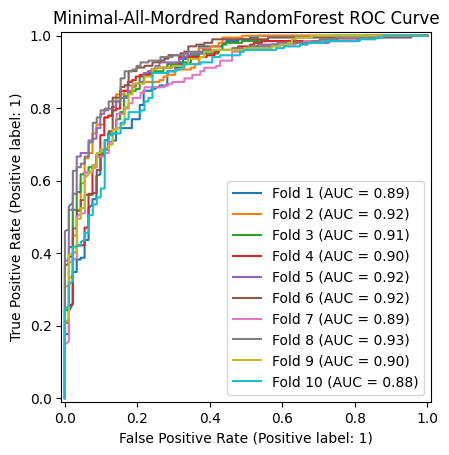

In [53]:
# loop through each model, perform grid search, and evaluate

all_metrics = []

import matplotlib.pyplot as plt
from scipy.stats import sem
for model_name in ['RandomForest']: #'RandomForest', 'SVM', 'LogisticRegression', 'NeuralNetwork'
    print(f"\nTraining and evaluating {model_name}...")
    t0 = time.time()
    pipeline = get_model_pipeline(model_name)
    param_grid = param_grids[model_name]
    grid_search = perform_grid_search(pipeline, param_grid, X_train, y_train)
    model = grid_search.best_estimator_
    print(f"Time taken : {time.time() - t0:.2f}s\n")
    print(f"Hyperparameters: {grid_search.best_params_}\n")
    metrics_model = evaluate_model_with_cv(model, X_train, y_train, model_name, random_state=22)
    df_metrics = pd.DataFrame(metrics_model)

    df_metrics['Model'] = model_name

    all_metrics.append(df_metrics) #get list with all metrics for each model


Training and evaluating DummyClassifier...
Average accuracy: 0.6632 	 and std err: 0.0086
Average precision: 0.7836 	 and std err: 0.0041
Average F1 score: 0.7851 	 and std err: 0.0067
Average AUC score: 0.4888 	 and std err: 0.0108
Average Cohens kappa: 0.0017 	 and std err: 0.0192
Time taken : 0.44s



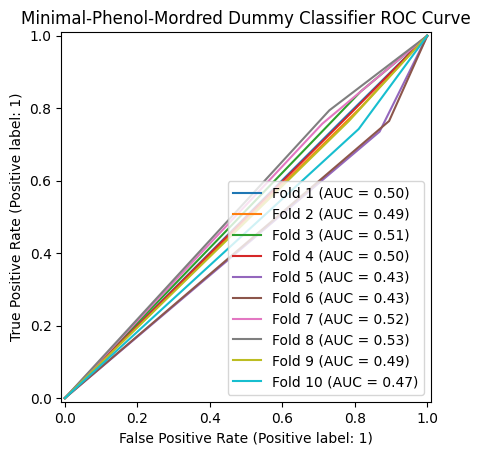

In [ ]:
# prompt: get metrics for dummy classifier and make a bar plot comparing the performances of all models regarding the metrics

from sklearn.dummy import DummyClassifier
from scipy import stats

# Add DummyClassifier to the evaluation
model_name = 'Dummy Classifier'
dummy_model = DummyClassifier(strategy="stratified")
print("\nTraining and evaluating DummyClassifier...")
t0 = time.time()
metrics_dummy = evaluate_model_with_cv(dummy_model, X_train, y_train, model_name, random_state=22)
df_metrics_dummy = pd.DataFrame(metrics_dummy)
df_metrics_dummy['Model'] = 'DummyClassifier'
all_metrics.append(df_metrics_dummy)


all_metrics_df = pd.concat(all_metrics, ignore_index=True)

# Calculate mean metrics for each model
mean_metrics = all_metrics_df.groupby('Model').mean().reset_index()


all_metrics_df = pd.concat([all_metrics_df, mean_metrics], ignore_index=True)


all_metrics_df.to_csv(f"{path}{filename}_metrics.csv", index=False)


<ipython-input-21-312411bbec62>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model', ci='sd')


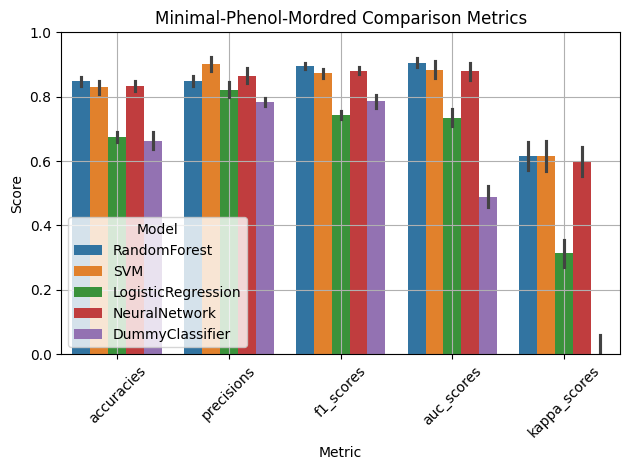

In [ ]:
# plot the barplot with all the metrics
import seaborn as sns

metrics_melted = all_metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(data=metrics_melted, x='Metric', y='Score', hue='Model', ci='sd')
plt.title(f"{filename} Comparison Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig(f"{path}{filename}_metrics_barplot.png")
plt.show()
